# 2024年度 データサイエンス実習 最終課題
## 23vr008n 三宅研 修士2年 高林 秀

# レポート説明

- 選択した問題：選択肢① プロ野球Freak
- 概要・注意事項
    - 「2009年から2023年までの⽇付や対戦相⼿など5-6の指標 (説明変数)を元にホームゲームの観客数を予測する回帰モデルを作り、重要な指標を理解する」
    - 説明変数は、適宜、充⾜・削除・作成して頂いて構いません。(2020年のデータは除き、スワローズ以外のチームにして下さい)

# 問題設定
- 予測するチーム：`横浜DeNAベイスターズ`
- 目的変数：ホームゲームの観客数
- 説明変数
    - 試合日程 (年,日付)
    - 勝敗
    - スコア
    - 対戦相手
    - 先発投手
- 使用するモデル：//TODO:後で埋める

- データ元URL：https://baseball-freak.com/audience/23/baystars.html

In [223]:
from typing import Final as const
from IPython.display import display, Markdown
import pandas as pd
from pandas.core.series import Series as Row #TypeHint用
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import matplotlib_fontja
import joblib

from tqdm import tqdm
import re


In [224]:
# インポートするデータの条件指定
data_year_range: const[tuple] = (9, 23)
team: const[str] = "baystars"
base_url: const[str] = "https://baseball-freak.com/audience/"

years_array = np.arange(data_year_range[0], data_year_range[1]+1)
#2020年は除外
years: list[int] = years_array[years_array != 20].tolist()
years

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23]

In [225]:
# 指定範囲年のデータのインポート
datas: list[pd.DataFrame] = []
for year in tqdm(years, desc="Fetching Data...."):
    if(year == 20):
        continue
    else:
        url = f"{base_url}{year:02}/{team}.html"
        dfs = pd.read_html(url)
        datas.append(dfs[2])
else:
    print("Done")


Fetching Data....: 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]

Done


In [226]:
# 年数のカラムを追加し、DataFrameを１つにまとめる。
for df, year in zip(datas,  years):
    if(year == 20):
        continue
    df['年'] = year

dataset = pd.concat(datas, ignore_index=True)
dataset

,日付,観客数,勝敗,スコア,対戦相手,先発投手,試合時間,球場,日付.1,年
0,4月7日(火),"20,168 人",●,1 - 5,巨人,寺原,3:45,横浜,4月7日(火),9
1,4月8日(水),"16,361 人",●,1 - 12,巨人,工藤,3:10,横浜,4月8日(水),9
2,4月9日(木),"16,691 人",●,2 - 9,巨人,ウォーランド,3:15,横浜,4月9日(木),9
3,4月10日(金),"12,791 人",○,9 - 1,ヤクルト,三浦,2:46,横浜,4月10日(金),9
4,4月11日(土),"17,817 人",●,0 - 3,ヤクルト,グリン,3:23,横浜,4月11日(土),9
...,...,...,...,...,...,...,...,...,...,...
1066,9月25日(月),"33,271 人",○,1 - 0,巨人,大貫,3:13,横浜,9月25日(月),23
1067,9月26日(火),"33,262 人",○,1 - 0,巨人,東,2:31,横浜,9月26日(火),23
1068,9月27日(水),"33,254 人",●,3 - 11,ヤクルト,坂本,3:02,横浜,9月27日(水),23
1069,9月29日(金),"33,267 人",○,5 - 3,阪神,石田,4:00,横浜,9月29日(金),23


In [227]:
# 欠損値のある行は除外する。
dataset.replace('-', np.nan, inplace=True)
dataset.replace('中止', np.nan, inplace=True)
dataset.dropna(inplace=True)
dataset.notna().any()

日付      True
観客数     True
勝敗      True
スコア     True
対戦相手    True
先発投手    True
試合時間    True
球場      True
日付.1    True
年       True
dtype: bool

In [228]:
# 説明変数のみを残す
dataset.drop(columns=["球場", "日付.1", "試合時間",], inplace=True)
dataset


,日付,観客数,勝敗,スコア,対戦相手,先発投手,年
0,4月7日(火),"20,168 人",●,1 - 5,巨人,寺原,9
1,4月8日(水),"16,361 人",●,1 - 12,巨人,工藤,9
2,4月9日(木),"16,691 人",●,2 - 9,巨人,ウォーランド,9
3,4月10日(金),"12,791 人",○,9 - 1,ヤクルト,三浦,9
4,4月11日(土),"17,817 人",●,0 - 3,ヤクルト,グリン,9
...,...,...,...,...,...,...,...
1066,9月25日(月),"33,271 人",○,1 - 0,巨人,大貫,23
1067,9月26日(火),"33,262 人",○,1 - 0,巨人,東,23
1068,9月27日(水),"33,254 人",●,3 - 11,ヤクルト,坂本,23
1069,9月29日(金),"33,267 人",○,5 - 3,阪神,石田,23


In [229]:
def plot_dataset(counts: pd.Series, title: str, x_lavel: str, y_label: str):
    plt.figure(figsize=(8, 6))
    counts.plot(kind='bar')
    plt.xlabel(x_lavel)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

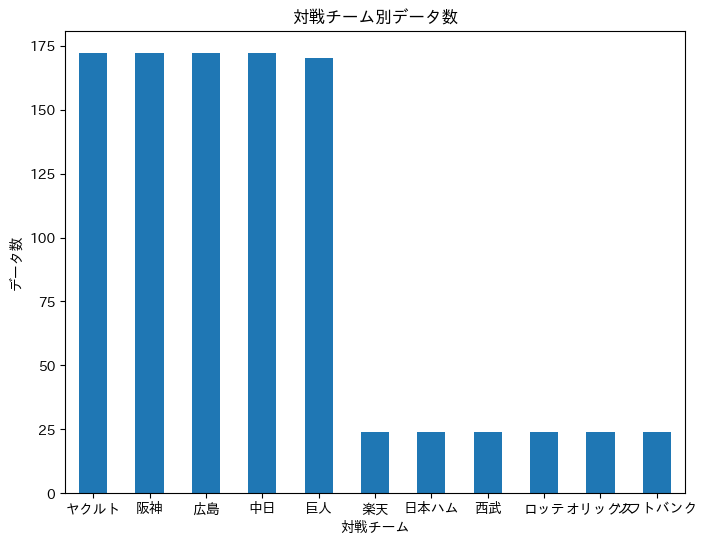

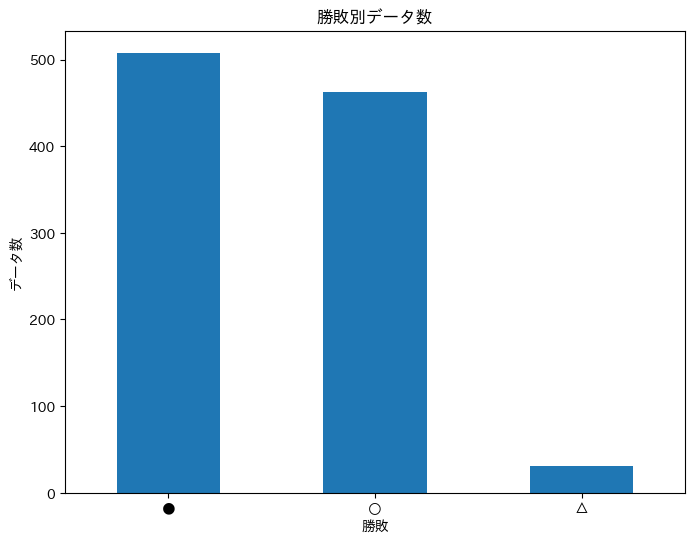

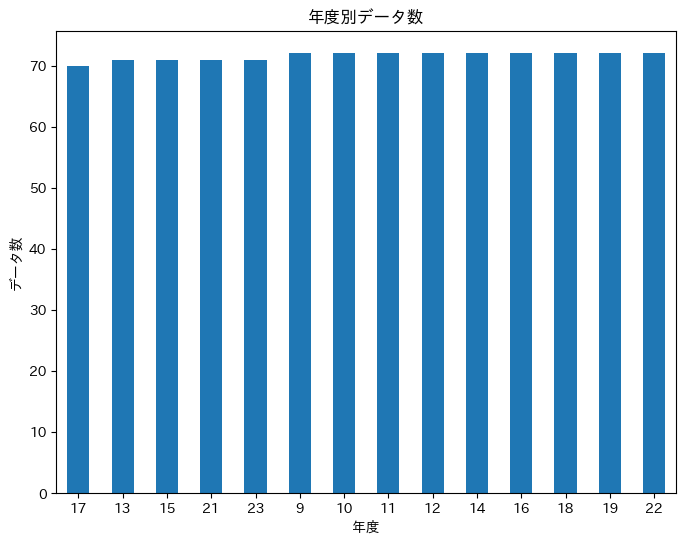

In [230]:
# チーム別可視化
team_counts = dataset['対戦相手'].value_counts()
plot_dataset(team_counts, "対戦チーム別データ数", "対戦チーム", "データ数")

#勝敗可視化
win_counts = dataset['勝敗'].value_counts()
plot_dataset(win_counts, "勝敗別データ数", "勝敗", "データ数")

#年度別データ数
years_counts = dataset['年'].value_counts().sort_values()
plot_dataset(years_counts, "年度別データ数", "年度", "データ数")

In [231]:
# データの成形・前処理

# 観客数の単位（人）をのぞく
def remove_unit(value: str):
    return int(value[:-1].replace(',', ''))

dataset['観客数'] = dataset['観客数'].apply(remove_unit)

# スコアを自軍スコアと相手スコアに分ける
dataset[['自軍スコア', '相手スコア']] = dataset['スコア'].str.split('-', expand=True)
dataset["自軍スコア"] = dataset['自軍スコア'].astype(int)
dataset['相手スコア'] = dataset['相手スコア'].astype(int)
dataset.drop(columns=["スコア"], inplace=True)

#勝敗：勝ち（○）= true, 負け（●） = falseとしてエンコーディングする
dataset["勝利"] = dataset['勝敗'].apply(lambda v: True if v == '○' else False)
dataset.drop(columns=["勝敗"], inplace=True)

# 対戦相手と先発投手をonehotエンコーディングする
df_encoded = pd.get_dummies(dataset, columns=["対戦相手", "先発投手"])

# 日付データの成形
df_encoded['年'] = df_encoded['年'].apply(lambda v: 2000 + int(v))
def convine_date_year(row: Row):
    date_str = row['日付']
    year = row['年']
   
    match = re.match(r'(\d+)月(\d+)日', date_str)
    if match:
        month = int(match.group(1))
        day = int(match.group(2))
        return pd.Timestamp(year=year, month=month, day=day)
    else:
        return None 

df_encoded['年月日'] = df_encoded.apply(convine_date_year, axis=1)
df_encoded.drop(columns=['日付', '年'], inplace=True)
df_encoded['年月日'] = pd.to_datetime(df_encoded['年月日'], format='%Y-%m-%d')
#年, 月, 日データでそれぞれカラムを用意する
df_encoded['年'] = df_encoded['年月日'].dt.year
df_encoded['月'] = df_encoded['年月日'].dt.month
df_encoded['日'] = df_encoded['年月日'].dt.day
df_encoded['曜日'] = df_encoded['年月日'].dt.dayofweek
df_encoded['四半期'] = df_encoded['年月日'].dt.quarter
df_encoded.drop(columns=["年月日"], inplace=True)


df_encoded


,観客数,自軍スコア,相手スコア,勝利,対戦相手_オリックス,対戦相手_ソフトバンク,対戦相手_ヤクルト,対戦相手_ロッテ,対戦相手_中日,対戦相手_巨人,...,先発投手_阿斗里,先発投手_須田,先発投手_飯塚,先発投手_高崎,先発投手_高橋,年,月,日,曜日,四半期
0,20168,1,5,False,False,False,False,False,False,True,...,False,False,False,False,False,2009,4,7,1,2
1,16361,1,12,False,False,False,False,False,False,True,...,False,False,False,False,False,2009,4,8,2,2
2,16691,2,9,False,False,False,False,False,False,True,...,False,False,False,False,False,2009,4,9,3,2
3,12791,9,1,True,False,False,True,False,False,False,...,False,False,False,False,False,2009,4,10,4,2
4,17817,0,3,False,False,False,True,False,False,False,...,False,False,False,False,False,2009,4,11,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,33271,1,0,True,False,False,False,False,False,True,...,False,False,False,False,False,2023,9,25,0,3
1067,33262,1,0,True,False,False,False,False,False,True,...,False,False,False,False,False,2023,9,26,1,3
1068,33254,3,11,False,False,False,True,False,False,False,...,False,False,False,False,False,2023,9,27,2,3
1069,33267,5,3,True,False,False,False,False,False,False,...,False,False,False,False,False,2023,9,29,4,3


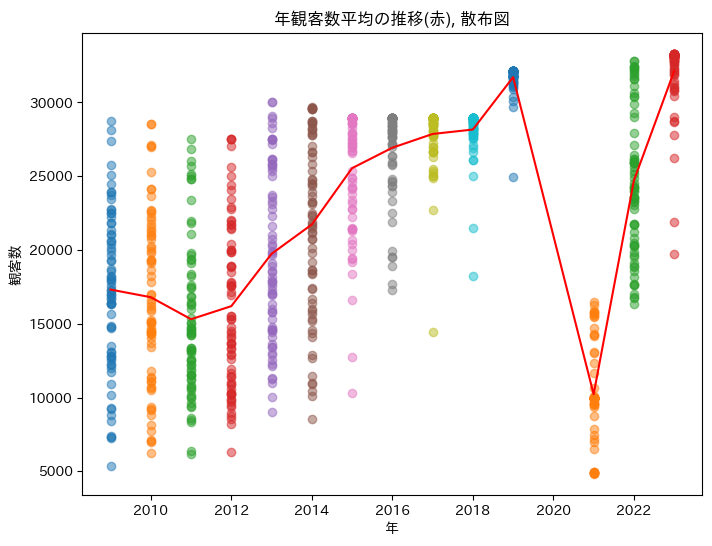

In [232]:
# 年数と年観客数平均の推移,散布図を確認

# 年度ごとの散布図
years = df_encoded['年'].unique()
audiences = df_encoded['観客数'].groupby(df_encoded['年'])

plt.figure(figsize=(8, 6))
for year, audience in audiences:
    plt.scatter([year] * len(audience), audience, alpha=0.5)
plt.title("年観客数平均の推移(赤), 散布図")
plt.xlabel("年")
plt.ylabel("観客数")
plt.plot(years, audiences.mean(), color='red')



Text(0, 0.5, '観客数')

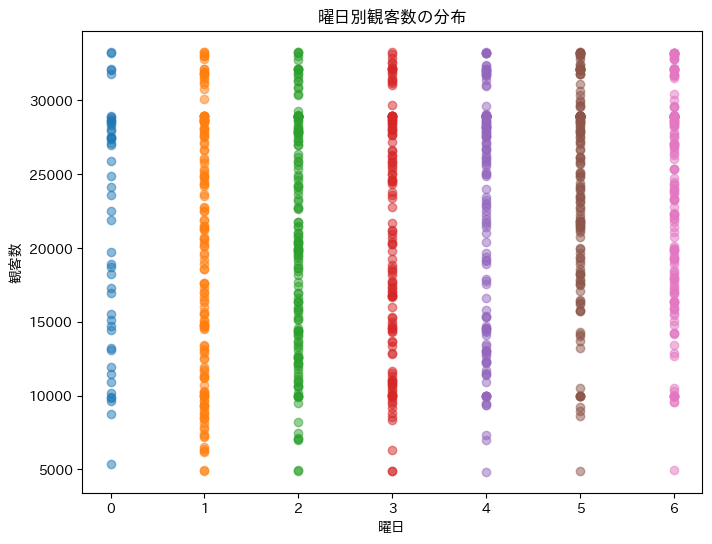

In [233]:
# 曜日と観客数の関係
weekdays = df_encoded['曜日'].unique()
audiences = df_encoded['観客数'].groupby(df_encoded['曜日'])

plt.figure(figsize=(8, 6))
for weekday, audience in audiences:
    plt.scatter([weekday] * len(audience), audience, alpha=0.5)
plt.title("曜日別観客数の分布")
plt.xlabel("曜日")
plt.ylabel("観客数")

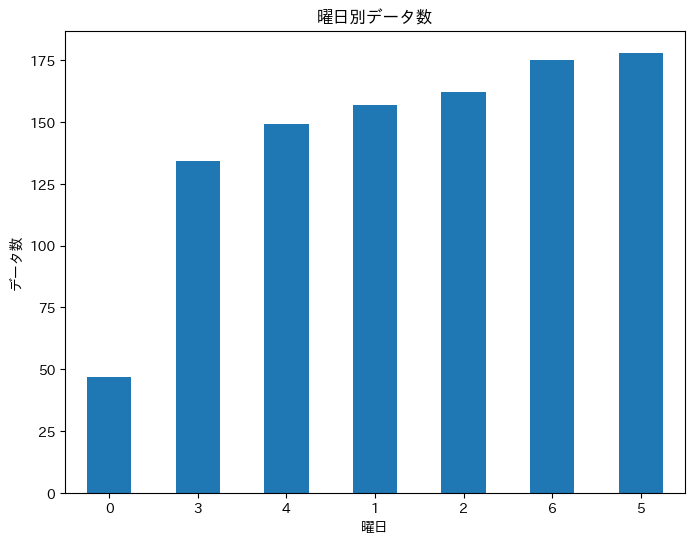

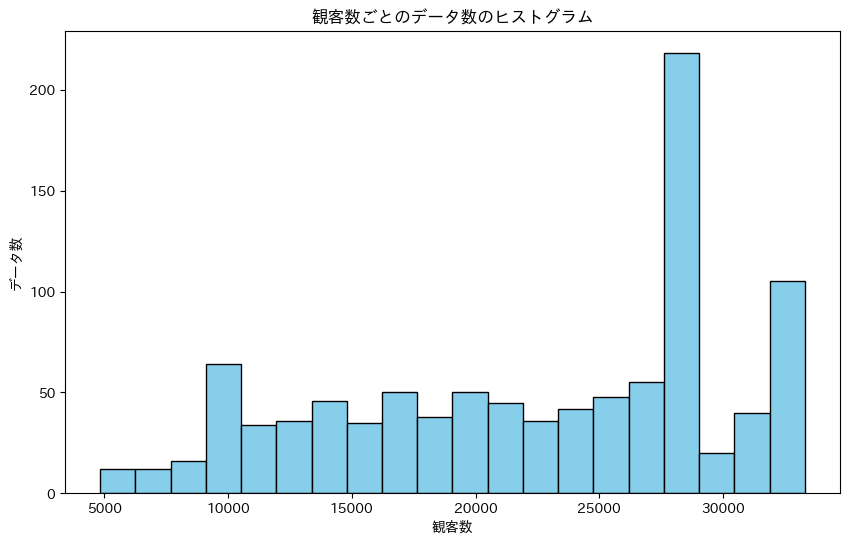

In [234]:
#曜日別データの可視化
day_counts = df_encoded['曜日'].value_counts().sort_values()
plot_dataset(day_counts, "曜日別データ数", "曜日", "データ数")

# 観客数のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(df_encoded['観客数'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('観客数')
plt.ylabel('データ数')
plt.title('観客数ごとのデータ数のヒストグラム')
plt.show()

In [235]:
# データセットの分割
target = "観客数"
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=515)

print(f"TrainData Size {X_train.shape}")
print(f"TestData Size {X_test.shape}")

TrainData Size (801, 95)
TestData Size (201, 95)


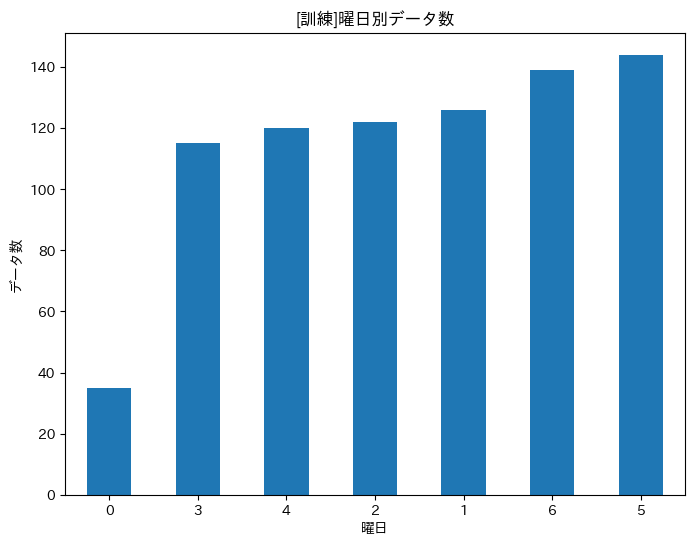

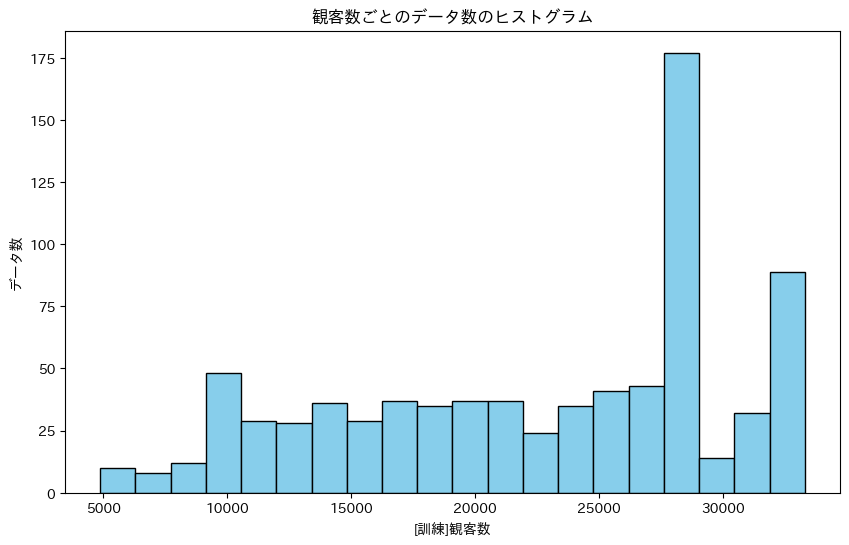

In [236]:
# 訓練データとテストデータの分布を確認

#訓練データ

#曜日別データの可視化
day_counts = X_train['曜日'].value_counts().sort_values()
plot_dataset(day_counts, "[訓練]曜日別データ数", "曜日", "データ数")

# 観客数のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('[訓練]観客数')
plt.ylabel('データ数')
plt.title('観客数ごとのデータ数のヒストグラム')
plt.show()

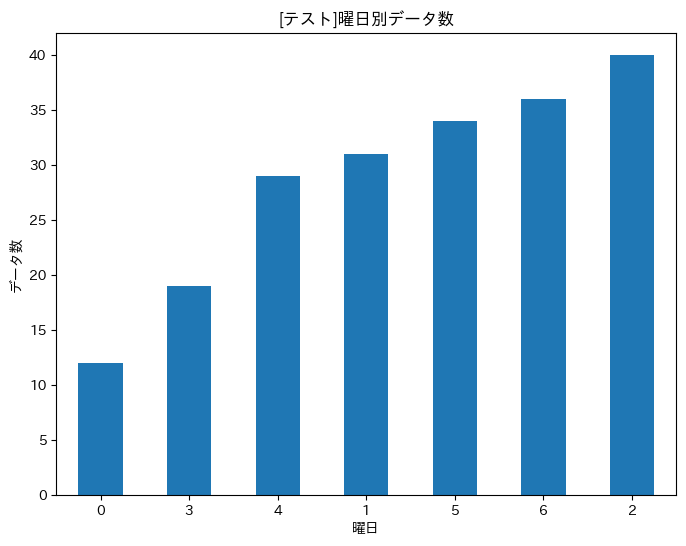

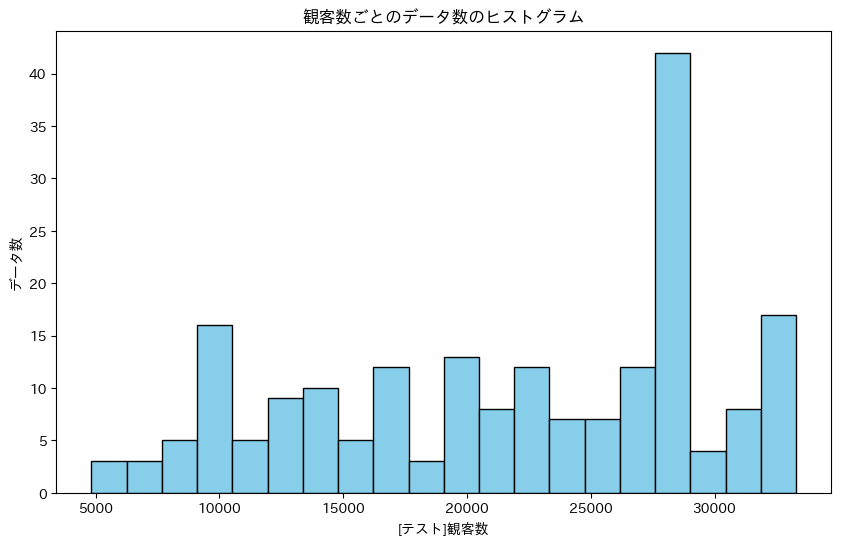

In [237]:
# テストデータ
#曜日別データの可視化
day_counts = X_test['曜日'].value_counts().sort_values()
plot_dataset(day_counts, "[テスト]曜日別データ数", "曜日", "データ数")

# 観客数のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('[テスト]観客数')
plt.ylabel('データ数')
plt.title('観客数ごとのデータ数のヒストグラム')
plt.show()

- 年数と観客数の関係を見る
- 曜日と観客数の関係を見る
- 年数を除いたモデルの作成と比較
- モデルの予測結果のプロット
- （発展）その日の気象情報（天候, 気温）

In [238]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 標準化
    ('regressor', DecisionTreeRegressor(random_state=515))  # 回帰モデル
])


# モデルの構築
grid_params = {
    'regressor__max_depth': [2, 4, 6, 8, 10, 12],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
}

models = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=10, scoring='r2', n_jobs=-1)
models.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=515))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [2, 4, 6, 8, 10, 12],
                         'regressor__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='r2')

In [239]:
# 最適モデルの抽出
best_model = models.best_estimator_
print(f"model param: {models.best_params_}")
print(f"model learning score: {models.best_score_}")

# 評価
y_pred = best_model.predict(X_test)

r2_value = r2_score(y_test, y_pred)
print(f"TEST R2: {r2_value}")


model param: {'regressor__max_depth': 8, 'regressor__min_samples_leaf': 12, 'regressor__min_samples_split': 2}
model learning score: 0.7402061768156207
TEST R2: 0.7725554943952927


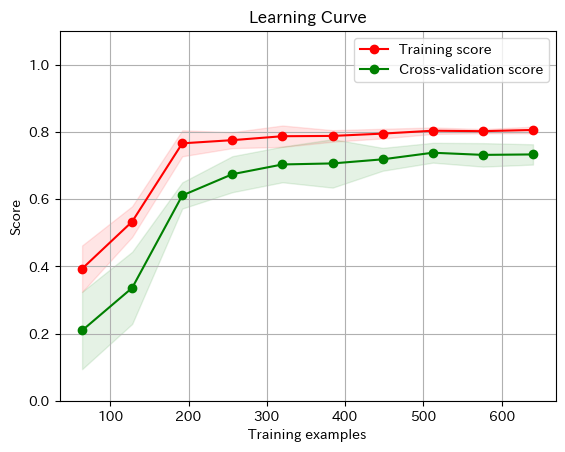

In [240]:
# 学習過程の可視化
train_sizes, train_scores, valid_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

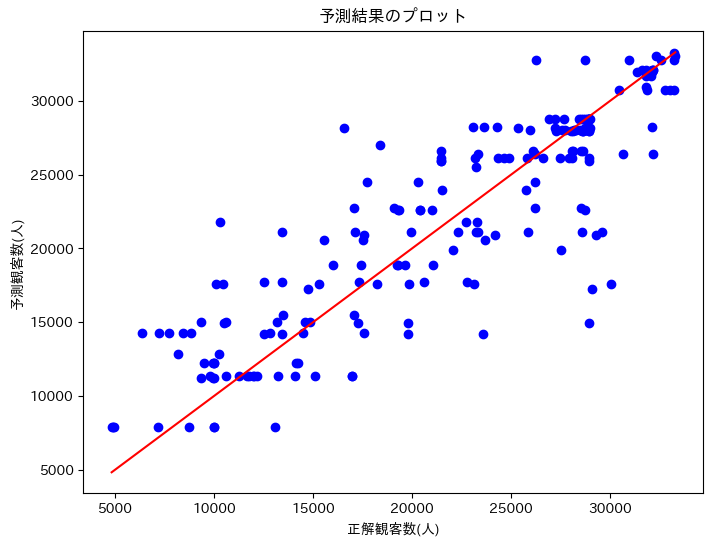

In [241]:
# 予測結果のプロット

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('正解観客数(人)')
plt.ylabel('予測観客数(人)')
plt.title('予測結果のプロット')
plt.show()

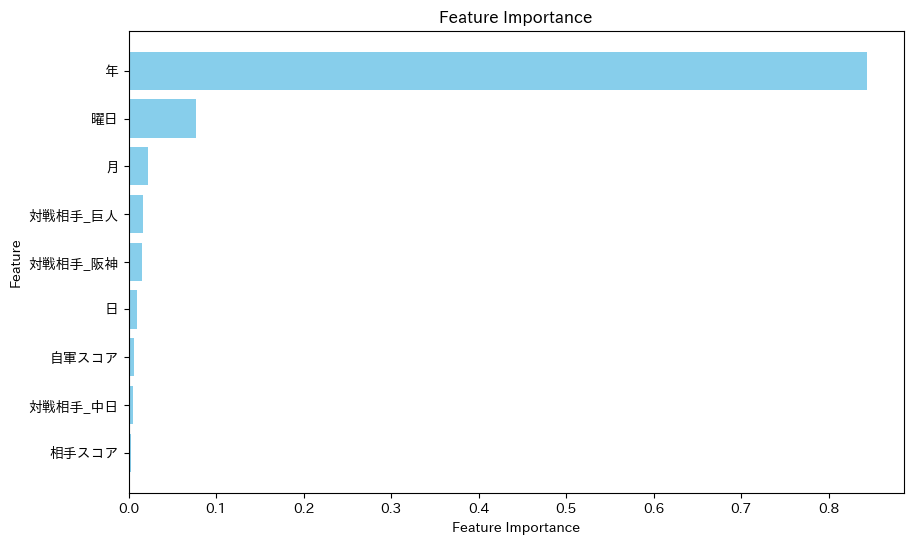

,Feature,Importance
90,年,0.843125
93,曜日,0.077264
91,月,0.022769
8,対戦相手_巨人,0.016910
13,対戦相手_阪神,0.015838
92,日,0.009868
0,自軍スコア,0.005969
7,対戦相手_中日,0.005446
1,相手スコア,0.002812


In [242]:
# 特徴重要度の取得
importances = best_model.named_steps['regressor'].feature_importances_

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df[importance_df['Importance'] >= 0.001].sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

importance_df


In [243]:
#モデルの保存
joblib.dump(best_model, './model.joblib')
print("Save model.")

Save model.


## (提出後) 年数を除いたモデルの作成

In [244]:
# データから年カラムを削除
target = "観客数"
X = df_encoded.drop(columns=[target, "年"])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=515)

print(f"TrainData Size {X_train.shape}")
print(f"TestData Size {X_test.shape}")

TrainData Size (801, 94)
TestData Size (201, 94)


In [245]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 標準化
    ('regressor', DecisionTreeRegressor(random_state=515))  # 回帰モデル
])


# モデルの構築
grid_params = {
    'regressor__max_depth': [2, 4, 6, 8, 10, 12],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
}

models = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=10, scoring='r2', n_jobs=-1)
models.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=515))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [2, 4, 6, 8, 10, 12],
                         'regressor__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='r2')

In [246]:
# 最適モデルの抽出
best_model = models.best_estimator_
print(f"model param: {models.best_params_}")
print(f"model learning score: {models.best_score_}")

# 評価
y_pred = best_model.predict(X_test)

r2_value = r2_score(y_test, y_pred)
print(f"TEST R2: {r2_value}")

model param: {'regressor__max_depth': 8, 'regressor__min_samples_leaf': 8, 'regressor__min_samples_split': 2}
model learning score: 0.1315107009908533
TEST R2: 0.249358758637224


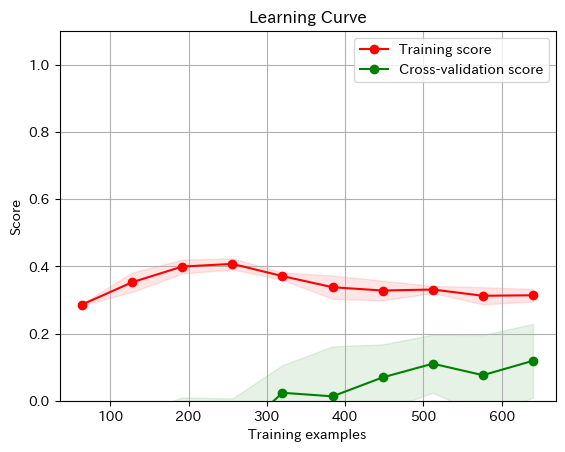

In [247]:
# 学習過程の可視化
train_sizes, train_scores, valid_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

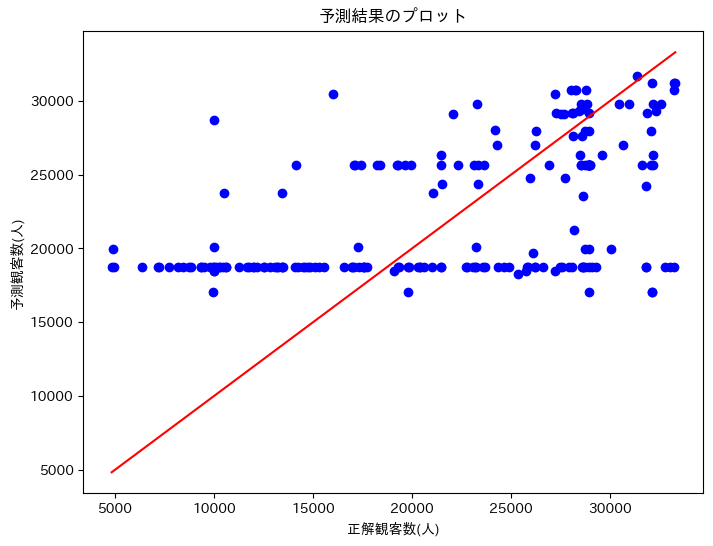

In [248]:
# 予測結果のプロット

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('正解観客数(人)')
plt.ylabel('予測観客数(人)')
plt.title('予測結果のプロット')
plt.show()

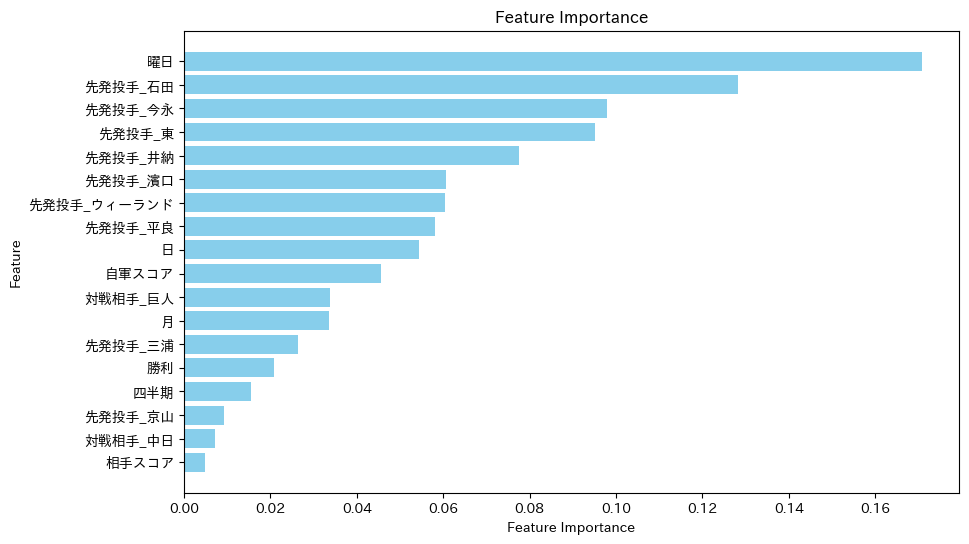

,Feature,Importance
92,曜日,0.170840
77,先発投手_石田,0.128210
45,先発投手_今永,0.097986
68,先発投手_東,0.095157
43,先発投手_井納,0.077474
71,先発投手_濱口,0.060646
14,先発投手_ウィーランド,0.060346
66,先発投手_平良,0.058049
91,日,0.054483
0,自軍スコア,0.045596


In [249]:
# 特徴重要度の取得
importances = best_model.named_steps['regressor'].feature_importances_

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df[importance_df['Importance'] >= 0.001].sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

importance_df


## （提出後）気象情報を加えたモデルの作成

- 使用するデータセット
    - 気象庁提供「過去の気象データ」
    - https://www.data.jma.go.jp/obd/stats/etrn/index.php
    
- 取得方法
    - 無料APIを作成・公開している方がいらっしゃったので、有難くそれを利用する
    - cultivationdata.net 様
    - https://www.cultivationdata.net/weather-web-api.html#past

- 学習データに追加する情報
    - 気温
    - 湿度
    - 降水量
    - 日照時間

In [250]:
# csvデータをDataFrameとして読み込む
weather_dfs = []
BASE_PATH = "./"
for year in range(2009, 2023, 2):
    start = year
    if start == 2021:
        start = 2022
    end = start+1 if year != 2019 else 2021
    file_path = f"{BASE_PATH}{start}-{end}/data.csv"
    columns = [
    "年月日", "平均気温(℃)", "品質情報1", "均質番号1",
    "最高気温(℃)", "品質情報2", "均質番号2", "最低気温(℃)",
    "品質情報3", "均質番号3", "降水量の合計(mm)", "現象なし情報1",
    "品質情報4", "均質番号4", "平均風速(m/s)", "品質情報5",
    "均質番号5", "日照時間(時間)", "現象なし情報2", "品質情報6",
    "均質番号6"
    ]

    # データをDataFrameとして読み込む（最初の5行をスキップして、カラム名を手動で設定）
    df = pd.read_csv(file_path, encoding='shift_jis', skiprows=6, names=columns)
    weather_dfs.append(df)

weather_dfs[3]


# データの結合
weather_df = pd.concat(weather_dfs, ignore_index=True)

# 年,月, 日カラムをそれぞれ作成（既存の年月日カラムを分割）
weather_df['年'] = weather_df['年月日'].apply(lambda v: int(v.split('/')[0]))
weather_df['月'] = weather_df['年月日'].apply(lambda v: int(v.split('/')[1]))
weather_df['日'] = weather_df['年月日'].apply(lambda v: int(v.split('/')[2]))

weather_df.drop(columns=['年月日'], inplace=True)
# weather_df.drop(columns=["降水量の合計(mm)"], inplace=True)

# カラム名に"品質情報"または"均質番号"を含むカラムを削除
weather_df.drop(columns=weather_df.columns[weather_df.columns.str.contains('品質情報|均質番号|現象なし情報')], inplace=True)
# 欠損値の確認と行の削除
weather_df.dropna(inplace=True)
print(weather_df.isna().any())

weather_df


平均気温(℃)       False
最高気温(℃)       False
最低気温(℃)       False
降水量の合計(mm)    False
平均風速(m/s)     False
日照時間(時間)      False
年             False
月             False
日             False
dtype: bool


,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),年,月,日
0,6.1,10.6,2.4,0.0,3.1,9.0,2009,1,1
1,6.9,12.5,2.3,0.0,3.2,8.0,2009,1,2
2,7.2,11.2,3.9,0.0,4.6,9.2,2009,1,3
3,7.4,12.0,4.0,0.0,3.4,8.2,2009,1,4
4,8.5,11.7,5.3,0.0,2.7,7.7,2009,1,5
...,...,...,...,...,...,...,...,...,...
5473,8.8,13.3,5.2,0.0,3.2,6.1,2023,12,27
5474,8.1,11.4,6.4,0.0,3.1,4.5,2023,12,28
5475,8.8,13.4,4.1,0.0,1.9,9.3,2023,12,29
5476,9.8,14.6,5.9,0.0,2.5,8.3,2023,12,30


In [251]:
# 気象データの概要

weather_df.describe()

,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),年,月,日
count,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000
mean,16.728026,20.710517,13.526182,4.819883,3.509987,5.821070,2015.999817,6.523279,15.727040
std,7.705378,7.885541,7.987291,14.375826,1.205297,4.192357,4.320754,3.449105,8.800742
min,0.300000,3.100000,-2.700000,0.000000,1.300000,0.000000,2009.000000,1.000000,1.000000
25%,9.700000,13.800000,6.200000,0.000000,2.700000,1.400000,2012.000000,4.000000,8.000000
50%,17.100000,20.900000,13.700000,0.000000,3.200000,6.500000,2016.000000,7.000000,16.000000
75%,23.000000,27.000000,20.200000,1.500000,4.000000,9.400000,2020.000000,10.000000,23.000000
max,32.200000,37.400000,28.400000,192.500000,9.100000,13.800000,2023.000000,12.000000,31.000000


In [252]:
# weather_dfで数値以外のデータを確認

def check_non_numeric(df: pd.DataFrame):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"{column}: {df[column].unique()}")
check_non_numeric(weather_df)



In [253]:
# df_encodedに組み込む。年, 月, 日の合致するデータを結合する
df_encoded = pd.merge(df_encoded, weather_df, on=['年', '月', '日'], how='left')
df_encoded

,観客数,自軍スコア,相手スコア,勝利,対戦相手_オリックス,対戦相手_ソフトバンク,対戦相手_ヤクルト,対戦相手_ロッテ,対戦相手_中日,対戦相手_巨人,...,月,日,曜日,四半期,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間)
0,20168,1,5,False,False,False,False,False,False,True,...,4,7,1,2,15.3,20.9,11.0,0.0,3.2,11.4
1,16361,1,12,False,False,False,False,False,False,True,...,4,8,2,2,15.6,21.5,11.2,0.0,3.2,9.2
2,16691,2,9,False,False,False,False,False,False,True,...,4,9,3,2,17.1,23.4,12.3,0.0,3.0,11.8
3,12791,9,1,True,False,False,True,False,False,False,...,4,10,4,2,17.8,23.6,13.4,0.0,4.5,12.2
4,17817,0,3,False,False,False,True,False,False,False,...,4,11,5,2,18.1,25.8,13.2,0.0,2.9,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,33271,1,0,True,False,False,False,False,False,True,...,9,25,0,3,22.8,27.7,19.1,0.0,3.8,6.0
998,33262,1,0,True,False,False,False,False,False,True,...,9,26,1,3,24.9,29.6,20.6,0.0,2.8,7.9
999,33254,3,11,False,False,False,True,False,False,False,...,9,27,2,3,26.0,29.9,23.7,0.0,2.2,4.4
1000,33267,5,3,True,False,False,False,False,False,False,...,9,29,4,3,26.7,29.6,25.0,0.0,2.9,3.9


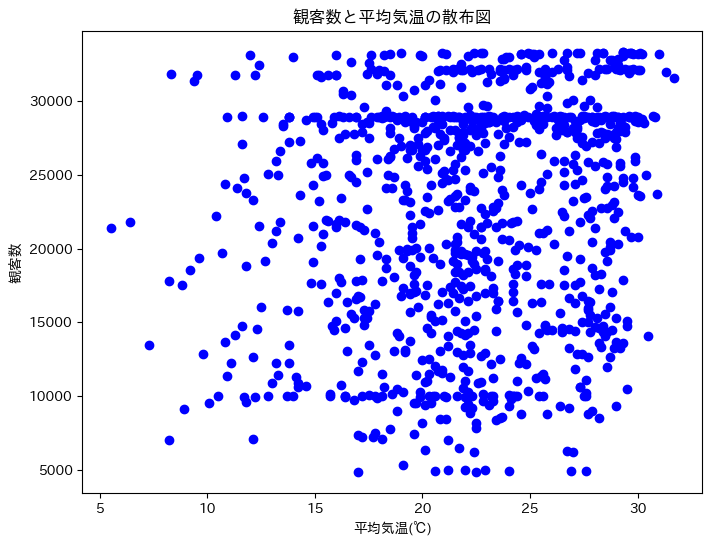

In [254]:
# 観客数と気象データの散布図を確認

plt.figure(figsize=(8, 6))
plt.scatter(df_encoded['平均気温(℃)'], df_encoded['観客数'], color='blue')
plt.xlabel('平均気温(℃)')
plt.ylabel('観客数')
plt.title('観客数と平均気温の散布図')
plt.show()

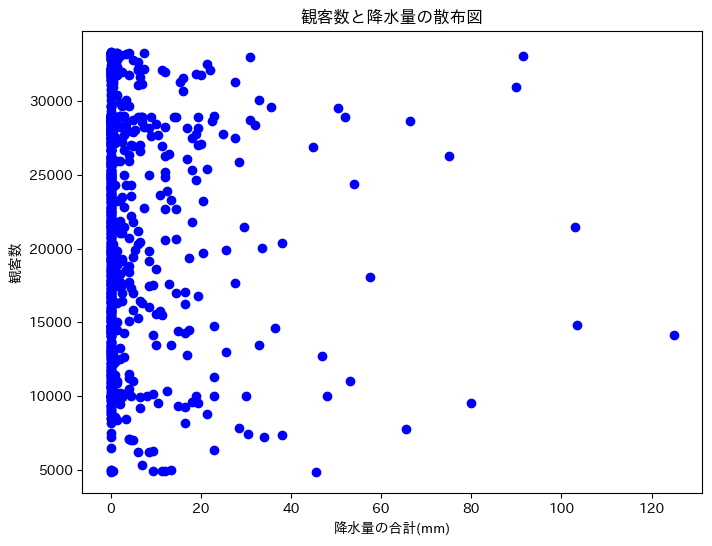

In [255]:
# 観客数と降水量の散布図を確認

plt.figure(figsize=(8, 6))
plt.scatter(df_encoded['降水量の合計(mm)'], df_encoded['観客数'], color='blue')
plt.xlabel('降水量の合計(mm)')
plt.ylabel('観客数')
plt.title('観客数と降水量の散布図')
plt.show()

In [256]:
target = "観客数"
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=515)

print(f"TrainData Size {X_train.shape}")
print(f"TestData Size {X_test.shape}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 標準化
    ('regressor', DecisionTreeRegressor(random_state=515))  # 回帰モデル
])


# モデルの構築
grid_params = {
    'regressor__max_depth': [2, 4, 6, 8, 10, 12],
    'regressor__min_samples_split': [1, 2, 5, 10],
    'regressor__min_samples_leaf': [18, 20, 30, 40, 50],
}

models = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=10, scoring='r2', n_jobs=-1)
models.fit(X_train, y_train,)

# 最適モデルの抽出
best_model = models.best_estimator_
print(f"model param: {models.best_params_}")
print(f"model learning score: {models.best_score_}")

# 評価
y_pred = best_model.predict(X_test)

r2_value = r2_score(y_test, y_pred)
print(f"TEST R2: {r2_value}")


TrainData Size (801, 101)
TestData Size (201, 101)
model param: {'regressor__max_depth': 6, 'regressor__min_samples_leaf': 20, 'regressor__min_samples_split': 2}
model learning score: 0.7358692914752123
TEST R2: 0.7325077504271601


c:\Users\syu\Learning\Class_DataScienceEX\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\syu\Learning\Class_DataScienceEX\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\syu\Learning\Class_DataScienceEX\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\syu\Learning\Class_DataScienc

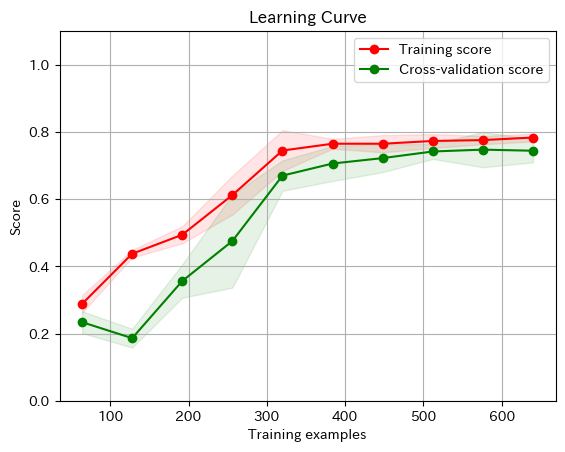

In [257]:
# 学習過程の可視化
train_sizes, train_scores, valid_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

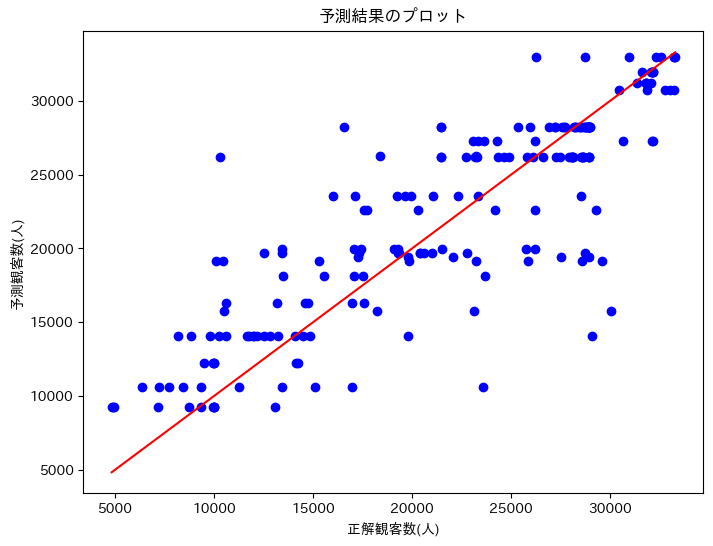

In [258]:
# 予測結果のプロット

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('正解観客数(人)')
plt.ylabel('予測観客数(人)')
plt.title('予測結果のプロット')
plt.show()

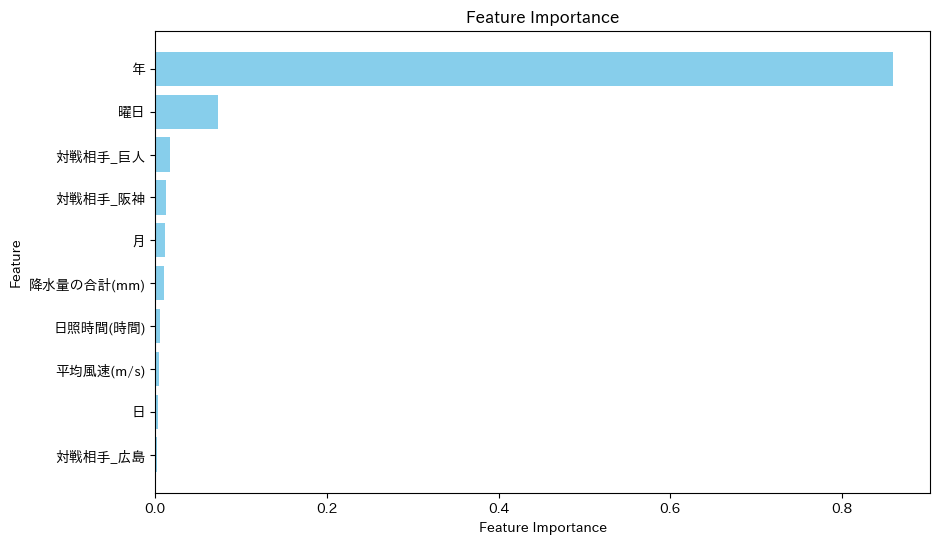

,Feature,Importance
90,年,0.860022
93,曜日,0.073195
8,対戦相手_巨人,0.017454
13,対戦相手_阪神,0.013019
91,月,0.011155
98,降水量の合計(mm),0.010476
100,日照時間(時間),0.005031
99,平均風速(m/s),0.003816
92,日,0.003147
9,対戦相手_広島,0.002503


In [259]:
# 特徴重要度の取得
importances = best_model.named_steps['regressor'].feature_importances_

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df[importance_df['Importance'] >= 0.001].sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

importance_df
